<a href="https://colab.research.google.com/github/LucasMello22/Detect_cofee/blob/master/project_final_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Iniciando

In [1]:
##Primeiro é necessario efetuar a ligação com o drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Processamento das imagens

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, ZeroPadding2D, Add, UpSampling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Parâmetros
path = "/content/drive/MyDrive/For_Model/Images"
batch_size_val = 20
steps_per_epoch_val = 31
epochs_val = 200
imageDimesions = (32, 32, 3)

## Importar Imagens
count = 0
images = []
classNo = []
pastas = os.listdir(path)
print("Total de Classes:", len(pastas))
noOfClasses = len(pastas)

for pt in range(0, len(pastas)):
    arquivos = os.listdir(path + "/" + str(count))
    for arq in arquivos:
        curImg = cv2.imread(path + "/" + str(count) + "/" + arq)
        if curImg is not None:
            curImg = cv2.resize(curImg, (imageDimesions[0], imageDimesions[1]))  # Redimensionar imagem
            images.append(curImg)
            classNo.append(count)
    count += 1

images = np.array(images)
classNo = np.array(classNo)

## Separando Imagens
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=0.4)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

## Funções do pré-processamento das Imagens
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def equalize(img):
    img = cv2.equalizeHist(img)
    return img

def preprocessing(img):
    img = grayscale(img)     # Converter em Gray
    img = equalize(img)      # Padronizar a Luminosidade das imagens
    img = img / 255          # Normalizar valores para 0 e 1 em vez de 0 e 255
    return img

## Pré-processar imagens
X_train = np.array(list(map(preprocessing, X_train)))
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))

## Regularizar Arrays
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

## Aumentando Imagens com ImageDataGenerator
dataGen = ImageDataGenerator(width_shift_range=0.1,   # Alterar posição width da imagem
                            height_shift_range=0.1,  # Alterar posição hight da imagem
                            zoom_range=0.2,          # Colocar zoom
                            shear_range=0.1,         # Mudar ângulo
                            rotation_range=10)       # Rotacionar imagem
dataGen.fit(X_train)
batches = dataGen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)

y_train = to_categorical(y_train, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)


Total de Classes: 8


# Modelo

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 6, 6, 64)          0         
                                                                 
 flatten (Flatten)           (None, 2304)              0

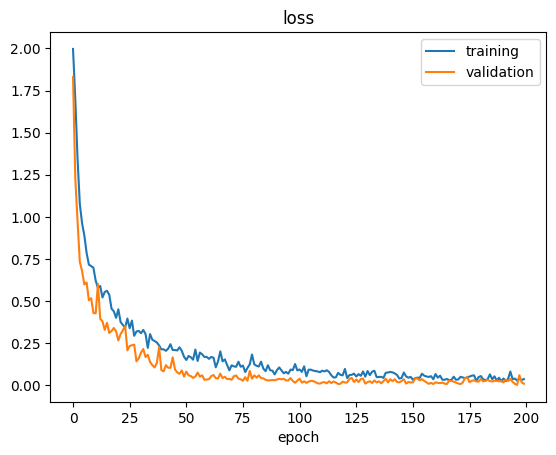

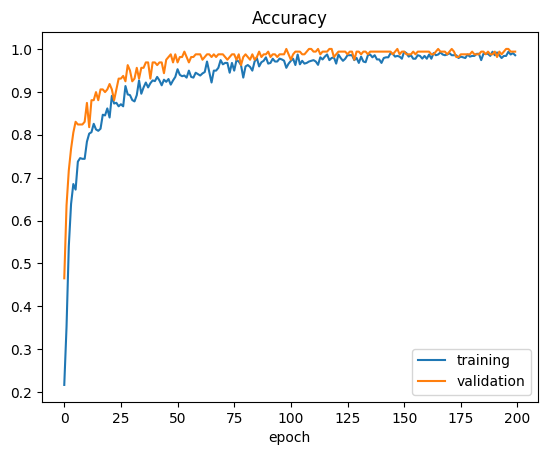

Test Score: 0.02045433409512043
Test Accuracy: 0.9905303120613098
Modelo Salvo!


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [4]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Flatten, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import os

## Criar Modelo
def myModel():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), input_shape=(imageDimesions[0], imageDimesions[1], 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(noOfClasses, activation='softmax'))

    # Configurar otimizador
    optimizer = Adam(learning_rate=0.001)

    # COMPILE MODEL
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

## Treinamento
model = myModel()
print(model.summary())

history = model.fit(dataGen.flow(X_train, y_train, batch_size=batch_size_val),
                    steps_per_epoch=steps_per_epoch_val,
                    epochs=epochs_val,
                    validation_data=(X_validation, y_validation),
                    shuffle=1)

## Mostrar histórico de treinamento
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')

plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

score = model.evaluate(X_test, y_test, verbose=0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

## Salvar modelo
model.save('modelo.h5')
print('Modelo Salvo!')


# Quantidade de passos por epoca (dado o tamanho do dataset)

In [7]:
steps_per_epoch_val = len(X_train) // 20

print(steps_per_epoch_val)


31


# Testando

Saving DSC_0003_11zon - Copia - Copia (2).jpg to DSC_0003_11zon - Copia - Copia (2).jpg
1/1 [==============================] - 0s 63ms/step
Predicted Class: Healthy
Predicted Value: 0
Probability: 100.0 %


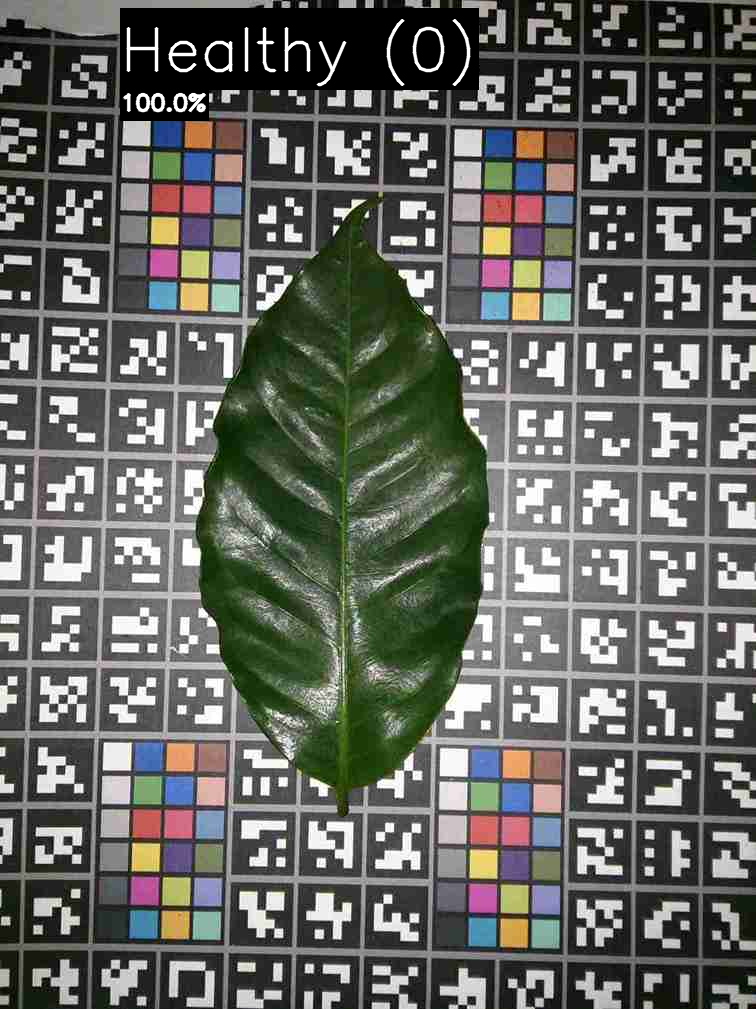

In [6]:
import numpy as np
import cv2
from keras.models import load_model
from google.colab import files
from IPython.display import Image, display

# Fazer upload do arquivo de imagem
uploaded = files.upload()

# Carregar o modelo
model = load_model('/content/modelo.h5')

def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def equalize(img):
    img = cv2.equalizeHist(img)
    return img

def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img / 255
    return img

def getClassName(classNo):
    class_names = {
        0: ('Healthy', 0),
        1: ('Cercosporiose', 1),
        2: ('Rust', 2),
        3: ('M. Areolada', 3),
        4: ('M Mantegosa', 4),
        5: ('Phoma', 5),
        6: ('Queimafio', 6),
        7: ('Rizoctoniose', 7)
    }
    return class_names.get(classNo, ('Unknown', None))

# Processar imagem carregada
for filename in uploaded.keys():
    imgOriginal = cv2.imread(filename)

    if imgOriginal is None:
        print("Failed to read image")
        continue

    img = np.asarray(imgOriginal)
    img = cv2.resize(img, (32, 32))
    img = preprocessing(img)
    img = img.reshape(1, 32, 32, 1)

    predictions = model.predict(img)
    indexVal = np.argmax(predictions)
    probabilityValue = np.amax(predictions)
    class_name, class_value = getClassName(indexVal)
    print("Predicted Class:", class_name)
    print("Predicted Value:", class_value)
    print("Probability:", round(probabilityValue * 100, 2), "%")

     # Definindo as coordenadas e tamanho do retângulo para o primeiro texto
    text1 = f"{class_name} ({class_value})"
    (x1, y1) = (120, 70)
    font_scale1 = 2
    (text_width1, text_height1), baseline1 = cv2.getTextSize(text1, cv2.FONT_HERSHEY_SIMPLEX, font_scale1, 2)

    # Desenhando o retângulo preto para o primeiro texto
    cv2.rectangle(imgOriginal, (x1, y1 - text_height1 - baseline1), (x1 + text_width1, y1 + baseline1), (0, 0, 0), cv2.FILLED)

    # Colocando o primeiro texto
    cv2.putText(imgOriginal, text1, (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2, cv2.LINE_AA)

    # Definindo as coordenadas e tamanho do retângulo para o segundo texto
    text2 = str(round(probabilityValue * 100, 2)) + "%"
    (x2, y2) = (120, 110)
    (text_width2, text_height2) = cv2.getTextSize(text2, cv2.FONT_HERSHEY_SIMPLEX, 0.75, 2)[0]

    # Desenhando o retângulo preto para o segundo texto
    cv2.rectangle(imgOriginal, (x2, y2 - text_height2 - 10), (x2 + text_width2, y2 + 10), (0, 0, 0), cv2.FILLED)

    # Colocando o segundo texto
    cv2.putText(imgOriginal, text2, (x2, y2), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255), 2, cv2.LINE_AA)

    # Mostrar imagem com resultados
    _, img_encoded = cv2.imencode('.png', imgOriginal)
    display(Image(data=img_encoded))

    # Para salvar a imagem processada localmente (opcional)
    cv2.imwrite('/content/result.png', imgOriginal)


In [ ]:
import numpy as np
import cv2
from keras.models import load_model
from google.colab import files
from IPython.display import Image, display

# Fazer upload do arquivo de imagem
uploaded = files.upload()

# Carregar o modelo
model = load_model('/content/drive/MyDrive/For_Model/modelo.h5')

def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def equalize(img):
    img = cv2.equalizeHist(img)
    return img

def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img / 255
    return img

def getClassName(classNo):
    class_names = {
        0: ('Healthy', 20),
        1: ('Cercosporiose', 30),
        2: ('Rust', 50),
        3: ('M. Areolada', 60),
        4: ('M Mantegosa', 70),
        5: ('Phoma', 80),
        6: ('Queimafio', 100),
        7: ('Rizoctoniose', 120)
    }
    return class_names.get(classNo, ('Unknown', None))

# Processar imagem carregada
for filename in uploaded.keys():
    imgOriginal = cv2.imread(filename)

    if imgOriginal is None:
        print("Failed to read image")
        continue

    img = np.asarray(imgOriginal)
    img = cv2.resize(img, (32, 32))
    img = preprocessing(img)
    img = img.reshape(1, 32, 32, 1)

    predictions = model.predict(img)
    indexVal = np.argmax(predictions)
    probabilityValue = np.amax(predictions)
    class_name, class_value = getClassName(indexVal)
    print("Predicted Class:", class_name)
    print("Predicted Value:", class_value)
    print("Probability:", round(probabilityValue * 100, 2), "%")

     # Definindo as coordenadas e tamanho do retângulo para o primeiro texto
    text1 = f"{class_name} ({class_value})"
    (x1, y1) = (120, 70)
    font_scale1 = 2
    (text_width1, text_height1), baseline1 = cv2.getTextSize(text1, cv2.FONT_HERSHEY_SIMPLEX, font_scale1, 2)

    # Desenhando o retângulo preto para o primeiro texto
    cv2.rectangle(imgOriginal, (x1, y1 - text_height1 - baseline1), (x1 + text_width1, y1 + baseline1), (0, 0, 0), cv2.FILLED)

    # Colocando o primeiro texto
    cv2.putText(imgOriginal, text1, (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2, cv2.LINE_AA)

    # Definindo as coordenadas e tamanho do retângulo para o segundo texto
    text2 = str(round(probabilityValue * 100, 2)) + "%"
    (x2, y2) = (120, 110)
    (text_width2, text_height2) = cv2.getTextSize(text2, cv2.FONT_HERSHEY_SIMPLEX, 0.75, 2)[0]

    # Desenhando o retângulo preto para o segundo texto
    cv2.rectangle(imgOriginal, (x2, y2 - text_height2 - 10), (x2 + text_width2, y2 + 10), (0, 0, 0), cv2.FILLED)

    # Colocando o segundo texto
    cv2.putText(imgOriginal, text2, (x2, y2), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255), 2, cv2.LINE_AA)

    # Mostrar imagem com resultados
    _, img_encoded = cv2.imencode('.png', imgOriginal)
    display(Image(data=img_encoded))

    # Para salvar a imagem processada localmente (opcional)
    cv2.imwrite('/content/result.png', imgOriginal)


Saving 2-ferrugem-do-cafeeiro.webp to 2-ferrugem-do-cafeeiro (2).webp


TypeError: Error when deserializing class 'InputLayer' using config={'batch_shape': [None, 32, 32, 1], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_5'}.

Exception encountered: Unrecognized keyword arguments: ['batch_shape']

# Plot's


In [1]:
# Plotar acurácia e perda de treinamento e validação em uma única figura
plt.figure(figsize=(12, 6))

# Gráfico de Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Gráfico de Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined